In [6]:
import rawpy

import os, glob, re, json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Tuple

In [7]:
def carregar_imagem(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"[aviso] não consegui abrir: {path}")
    return img

def _regex_tail_number(s: str) -> int:
    """
    Extrai um número "útil" do fim do nome para ordenação. 
    Se não encontrar, tenta qualquer número em s; se ainda não, retorna 0.
    """
    base = os.path.basename(s)
    m = re.search(r'(\d+)(?=\D*$)', base)  # último bloco numérico antes do fim
    if m: return int(m.group(1))
    m2 = re.search(r'(\d+)', base)
    return int(m2.group(1)) if m2 else 0

def ordenar_arquivos_imagem(caminho_pasta: str) -> List[str]:
    padroes = ['*.jpg','*.jpeg','*.png','*.bmp','*.tif','*.tiff','*.webp']
    arquivos = []
    for p in padroes:
        arquivos.extend(glob.glob(os.path.join(caminho_pasta, p)))
    arquivos = list(set(arquivos))  # evita duplicados por padrões sobrepostos
    if not arquivos:
        return []
    arquivos.sort(key=lambda f: (_regex_tail_number(f), os.path.basename(f).lower()))
    return arquivos

def serializar_keypoints(kps: List[cv2.KeyPoint]) -> np.ndarray:
    """
    Converte lista de cv2.KeyPoint para array (N,7) -> (x,y,size,angle,response,octave,class_id)
    """
    if not kps:
        return np.zeros((0,7), dtype=np.float32)
    data = np.zeros((len(kps),7), dtype=np.float32)
    for i,k in enumerate(kps):
        data[i,0] = k.pt[0]
        data[i,1] = k.pt[1]
        data[i,2] = k.size
        data[i,3] = k.angle
        data[i,4] = k.response
        data[i,5] = k.octave
        data[i,6] = k.class_id
    return data

def criar_detector(nome: str):
    nome = nome.lower()
    if nome == 'sift':
        return cv2.SIFT_create(), cv2.NORM_L2, 'sift'
    if nome == 'orb':
        return cv2.ORB_create(nfeatures=2000), cv2.NORM_HAMMING, 'orb'
    if nome == 'akaze':
        return cv2.AKAZE_create(), cv2.NORM_HAMMING, 'akaze'
    raise ValueError(f"Detector '{nome}' não reconhecido.")

In [8]:
def desenhar_keypoints_custom(imagem, keypoints, cor=(0, 255, 0), raio=3, espessura=2):
    """
    Desenha keypoints em uma imagem com círculos customizáveis.
    
    Args:
        imagem: A imagem (colorida, BGR) onde desenhar.
        keypoints: Lista de cv2.KeyPoint.
        cor: Tupla BGR para a cor dos círculos.
        raio: Raio de cada círculo.
        espessura: Espessura da borda do círculo (-1 para preenchido).
        
    Returns:
        Uma nova imagem com os keypoints desenhados.
    """
    # Cria uma cópia para não modificar a imagem original
    img_desenhada = imagem.copy()

    if keypoints is None:
        return img_desenhada

    for kp in keypoints:
        center = (int(kp.pt[0]), int(kp.pt[1]))
        cv2.circle(img_desenhada, center, raio, cor, espessura)

    return img_desenhada


def desenhar_matches_custom(
    img1, kps1, img2, kps2, matches,
    num_matches_a_desenhar=25,
    cor_linha=(255, 0, 255), espessura_linha=4,
    cor_ponto=(0, 255, 0), raio_ponto=20
):
    """
    Desenha matches entre duas imagens com linhas e pontos customizáveis.

    Args:
        img1, kps1: Imagem da esquerda e seus keypoints.
        img2, kps2: Imagem da direita e seus keypoints.
        matches: Lista de objetos cv2.DMatch.
        num_matches_a_desenhar: Quantidade dos melhores matches a serem desenhados.
        cor_linha, espessura_linha: Cor (BGR) e espessura para as linhas de match.
        cor_ponto, raio_ponto: Cor (BGR) e raio para os círculos nos keypoints.

    Returns:
        Uma nova imagem com os matches desenhados.
    """
    # 1. Cria a imagem de saída combinando as duas imagens lado a lado
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    output_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    output_img[:h1, :w1] = img1
    output_img[:h2, w1:] = img2

    # Assegura que temos keypoints para desenhar
    if kps1 is None or kps2 is None:
        return output_img

    # 2. Itera sobre os melhores matches e desenha as linhas e pontos
    for match in matches[:num_matches_a_desenhar]:
        # Ponto na imagem da esquerda
        pt1_idx = match.queryIdx
        pt1 = (int(kps1[pt1_idx].pt[0]), int(kps1[pt1_idx].pt[1]))

        # Ponto na imagem da direita (com offset na coordenada x)
        pt2_idx = match.trainIdx
        pt2 = (int(kps2[pt2_idx].pt[0] + w1), int(kps2[pt2_idx].pt[1]))

        # Desenha a linha com espessura customizada
        cv2.line(output_img, pt1, pt2, cor_linha, espessura_linha)

        # Desenha os círculos nas pontas para maior destaque (círculos preenchidos)
        cv2.circle(output_img, pt1, raio_ponto, cor_ponto, thickness=-1)
        cv2.circle(output_img, pt2, raio_ponto, cor_ponto, thickness=-1)

    return output_img

In [11]:
# --------- ETAPA 2 PRINCIPAL (Refinada com Visualização de Matches Customizada) ---------
def analisar_conjunto(caminho_pasta: str, detectores: List[str]):
    """
    Etapa 2: 
    - Extrai e visualiza keypoints/descritores (SIFT/ORB/AKAZE).
    - Salva artefatos para as próximas etapas (.npz por imagem+detector).
    - Gera resumo comparativo (CSV).
    """
    print("=========================================================")
    print(f"Analisando o conjunto de imagens em: '{caminho_pasta}'")
    print("=========================================================")

    raiz_resultados = os.path.join(
        "resultados_etapa2", os.path.basename(os.path.normpath(caminho_pasta)))
    os.makedirs(raiz_resultados, exist_ok=True)

    arquivos_de_imagem = ordenar_arquivos_imagem(caminho_pasta)
    if len(arquivos_de_imagem) < 2:
        print("Erro: São necessárias pelo menos 2 imagens na pasta.")
        return

    ordem_json = os.path.join(raiz_resultados, "ordem_imagens.json")
    with open(ordem_json, "w", encoding="utf-8") as f:
        json.dump(arquivos_de_imagem, f, indent=2, ensure_ascii=False)
    print(f"-> Ordem das imagens salva em '{ordem_json}'")

    linhas_resumo = []

    for nome_detector in detectores:
        print(f"\n--- Análise para o detector: {nome_detector.upper()} ---")
        try:
            if nome_detector.lower() == 'sift':
                detector, norm_type, detector_slug = cv2.SIFT_create(
                    contrastThreshold=0.08), cv2.NORM_L2, 'sift'
            else:
                detector, norm_type, detector_slug = criar_detector(
                    nome_detector)
        except ValueError as e:
            print(e)
            continue

        dir_detector = os.path.join(raiz_resultados, detector_slug)
        os.makedirs(dir_detector, exist_ok=True)

        total_keypoints = 0
        kp_anterior, des_anterior, img_anterior_bgr = None, None, None

        for i, caminho in enumerate(arquivos_de_imagem):
            img_bgr = carregar_imagem(caminho)
            if img_bgr is None:
                continue

            img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = detector.detectAndCompute(img_gray, None)
            n_kp = 0 if keypoints is None else len(keypoints)
            total_keypoints += n_kp
            linhas_resumo.append(
                [detector_slug, os.path.basename(caminho), n_kp])

            arr_kp = serializar_keypoints(keypoints or [])
            if descriptors is None:
                descriptors = np.zeros((0, detector.descriptorSize() if hasattr(
                    detector, 'descriptorSize') else 0), dtype=np.uint8)
            saida_npz = os.path.join(dir_detector, f"img_{i:03d}_features.npz")
            np.savez_compressed(saida_npz, keypoints=arr_kp,
                                descriptors=descriptors, imagem_absoluta=caminho)

            img_kp = desenhar_keypoints_custom(
                img_bgr, keypoints, cor=(0, 255, 0), raio=3)
            saida_overlay = os.path.join(
                dir_detector, f"img_{i:03d}_keypoints.jpg")
            cv2.imwrite(saida_overlay, img_kp)

            if i == 0:
                plt.figure(figsize=(12, 8))
                plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
                plt.title(
                    f'Keypoints ({detector_slug.upper()}) em {os.path.basename(caminho)}')
                plt.axis('off')
                plt.show()

            if i > 0 and des_anterior is not None and descriptors is not None and len(des_anterior) > 0 and len(descriptors) > 0:
                bf = cv2.BFMatcher(norm_type, crossCheck=True)
                matches = bf.match(des_anterior, descriptors)
                matches = sorted(matches, key=lambda x: x.distance)

                if i == 1:
                    # <-- MUDANÇA: Substituído drawMatches pela nossa função customizada ---
                    # Agora temos controle total sobre a aparência.
                    preview = desenhar_matches_custom(
                        img_anterior_bgr, kp_anterior,
                        img_bgr, keypoints,
                        matches,
                        num_matches_a_desenhar=50,
                        espessura_linha=2
                    )

                    saida_match = os.path.join(
                        dir_detector, f"preview_matches_par_0-1.jpg")
                    cv2.imwrite(saida_match, preview)
                    plt.figure(figsize=(20, 10))
                    plt.imshow(cv2.cvtColor(preview, cv2.COLOR_BGR2RGB))
                    plt.title(
                        f'Top 50 Matches (preview) — {detector_slug.upper()} — img_000 ↔ img_001')
                    plt.axis('off')
                    plt.show()

            kp_anterior, des_anterior, img_anterior_bgr = keypoints, descriptors, img_bgr

        media_kp = total_keypoints / \
            len(arquivos_de_imagem) if arquivos_de_imagem else 0
        print("\n--- Resumo Estatístico ---")
        print(
            f"Média de keypoints por imagem ({detector_slug}): {media_kp:.2f}")

    import csv
    csv_path = os.path.join(raiz_resultados, "resumo_keypoints.csv")
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["detector", "imagem", "num_keypoints"])
        w.writerows(linhas_resumo)
    print(f"\n-> Resumo salvo em '{csv_path}'")

Analisando o conjunto de imagens em: 'images-normal'
-> Ordem das imagens salva em 'resultados_etapa2/images-normal/ordem_imagens.json'

--- Análise para o detector: SIFT ---


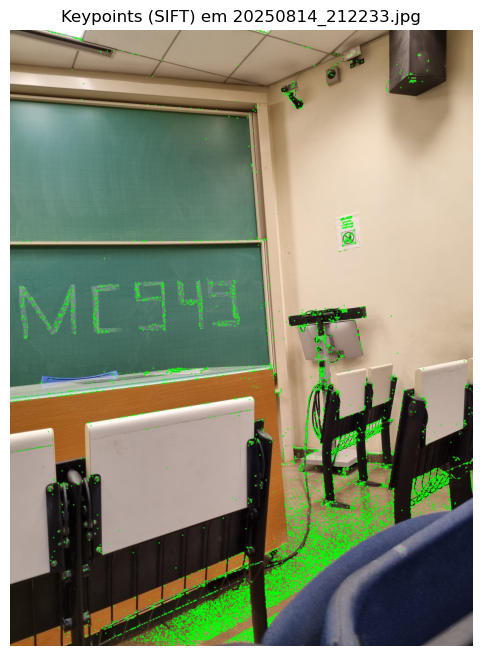

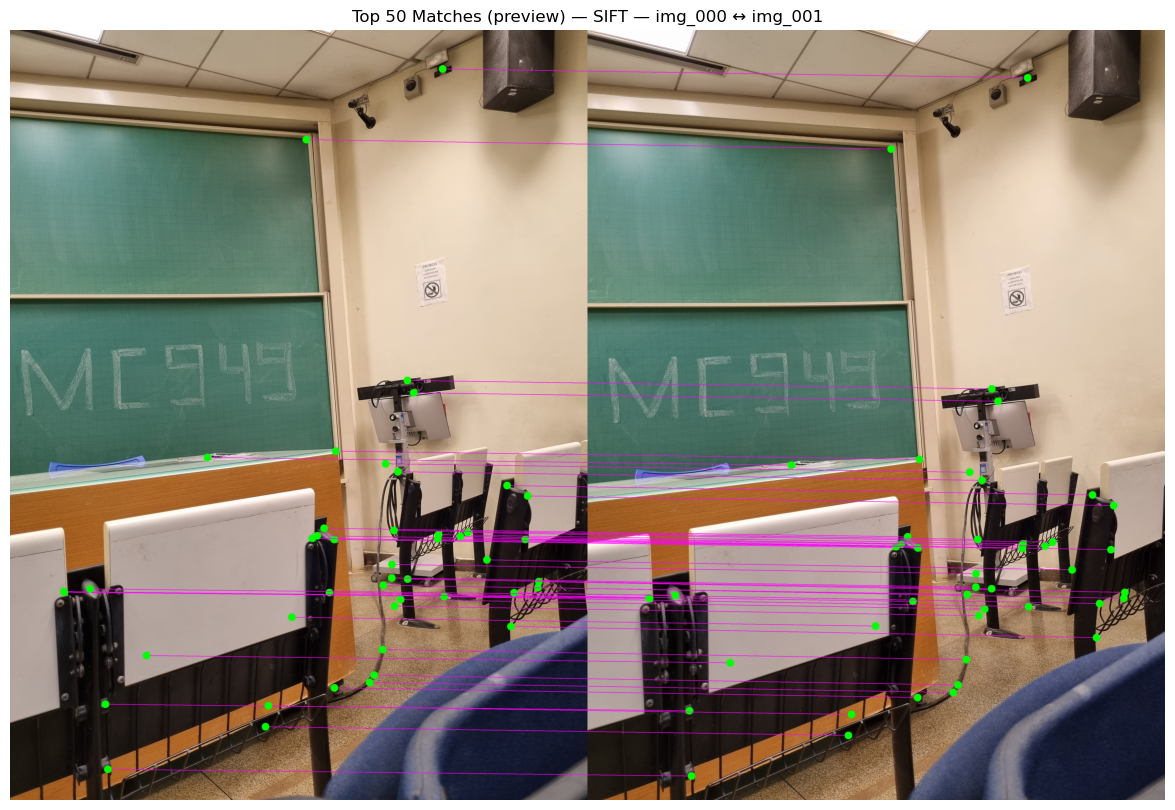


--- Resumo Estatístico ---
Média de keypoints por imagem (sift): 4609.13

--- Análise para o detector: ORB ---


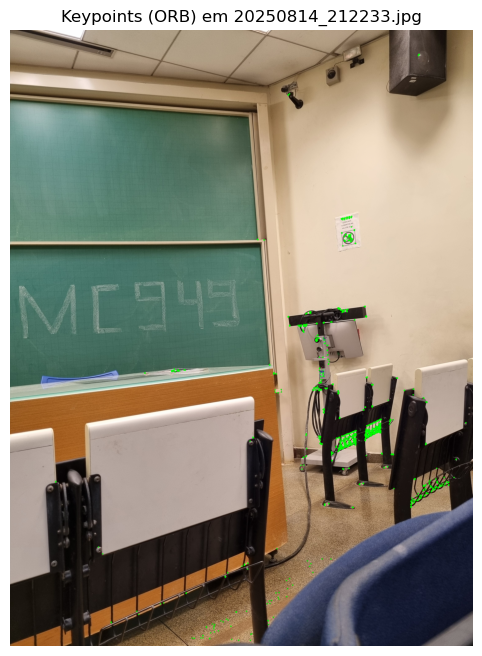

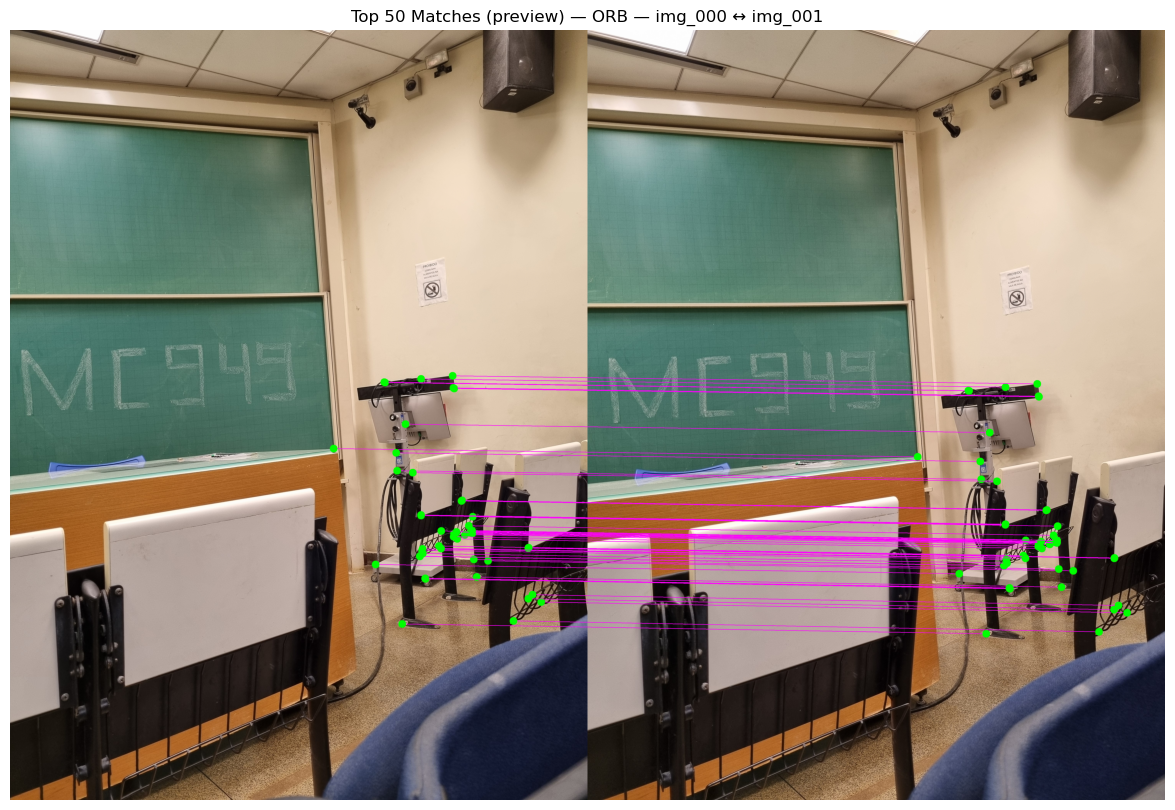


--- Resumo Estatístico ---
Média de keypoints por imagem (orb): 2000.00

--- Análise para o detector: AKAZE ---


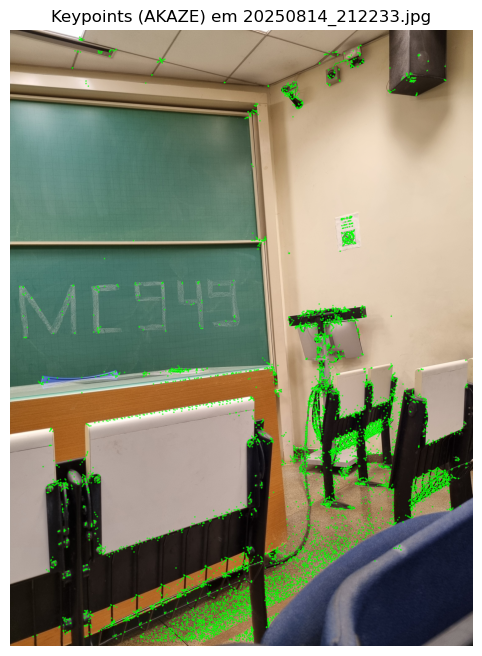

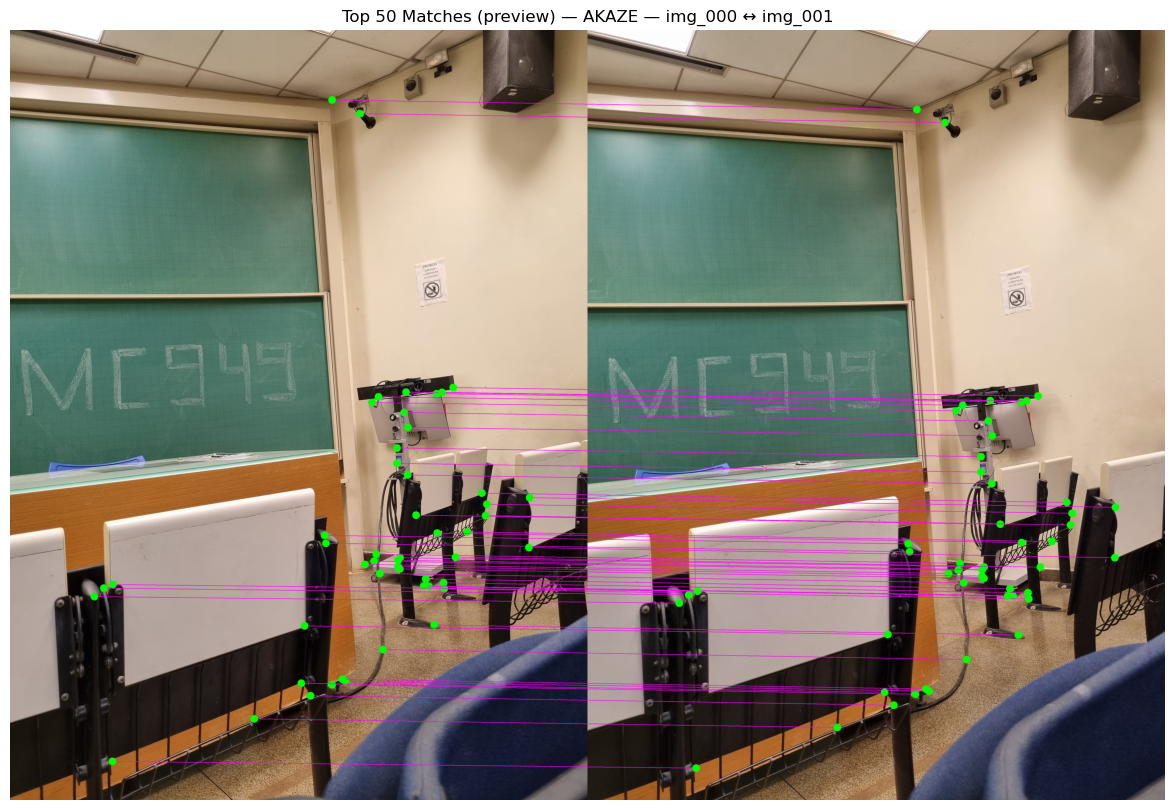


--- Resumo Estatístico ---
Média de keypoints por imagem (akaze): 3888.69

-> Resumo salvo em 'resultados_etapa2/images-normal/resumo_keypoints.csv'


In [12]:
caminho_normal = "images-normal"
detectores = ['sift', 'orb', 'akaze']
analisar_conjunto(caminho_normal, detectores)

In [ ]:
caminho_pro = "images-pro"
detectores = ['sift', 'orb', 'akaze']
analisar_conjunto(caminho_pro, detectores)

Analisando o conjunto de imagens em: 'images-pro'
Erro: São necessárias pelo menos 2 imagens na pasta.


In [ ]:
caminho_raw = "images-developed-png-8bit"
detectores = ['sift', 'orb', 'akaze']
analisar_conjunto(caminho_raw, detectores)

Analisando o conjunto de imagens em: 'images-developed-png-8bit'
Erro: São necessárias pelo menos 2 imagens na pasta.


In [ ]:
caminho_raw = "images-developed-png-16bit"
detectores = ['sift', 'orb', 'akaze']
analisar_conjunto(caminho_raw, detectores)

Analisando o conjunto de imagens em: 'images-developed-png-16bit'
Erro: São necessárias pelo menos 2 imagens na pasta.


In [ ]:
caminho_raw = "images-developed-tiff-8bit"
detectores = ['sift', 'orb', 'akaze']
analisar_conjunto(caminho_raw, detectores)

Analisando o conjunto de imagens em: 'images-developed-tiff-8bit'
Erro: São necessárias pelo menos 2 imagens na pasta.


In [ ]:
caminho_raw = "images-developed-tiff-16bit"
detectores = ['sift', 'orb', 'akaze']
analisar_conjunto(caminho_raw, detectores)

Analisando o conjunto de imagens em: 'images-developed-tiff-16bit'
Erro: São necessárias pelo menos 2 imagens na pasta.


In [ ]:
def desserializar_keypoints(arr: np.ndarray) -> List[cv2.KeyPoint]:
    """
    Reconstrói lista de cv2.KeyPoint a partir do array (N,7).
    """
    kps = []
    for row in arr:
        # (x,y,size,angle,response,octave,class_id)
        k = cv2.KeyPoint(
            x=float(row[0]),
            y=float(row[1]),
            size=float(row[2]),
            angle=float(row[3]),
            response=float(row[4]),
            octave=int(row[5]),
            class_id=int(row[6])
        )
        kps.append(k)
    return kps

# --------- Etapa 3+ ---------
def carregar_features_npz(caminho_npz: str) -> Tuple[List[cv2.KeyPoint], np.ndarray, str]:
    """
    Lê um .npz salvo pela Etapa 2 e retorna (keypoints, descriptors, imagem_absoluta).
    """
    data = np.load(caminho_npz, allow_pickle=True)
    kps = desserializar_keypoints(data["keypoints"])
    desc = data["descriptors"]
    img_path = str(data["imagem_absoluta"])
    return kps, desc, img_path

In [ ]:
# teste
kps1, desc1, path1 = carregar_features_npz("resultados_etapa2/images-normal/sift/img_000_features.npz")
print(len(kps1), desc1.shape, path1)

FileNotFoundError: [Errno 2] No such file or directory: 'resultados_etapa2/images-normal/sift/img_000_features.npz'